In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from model.utils.transfroms import get_train_transform, get_valid_transform, get_test_transform
from model.dataset import CustomDataset

HOME = ''
HOME_DIR = f'../Data/ChEMBL/OCR'
DATAFRAME_LIST = dict(train=f'data/chembl_31_smiles_train.csv',
                        val=f'data/chembl_31_smiles_val.csv',
                        test=f'data/chembl_31_smiles_test.csv')

def collate_fn(batch):
    return tuple(zip(*batch))

ocr_dataset = CustomDataset(
        data_df=DATAFRAME_LIST['val'],
        # mode='val',
        mode='test',
        # transforms=get_valid_transform(),
        # transforms=get_train_transform(),
        transforms=get_test_transform(),
        dir_path=HOME_DIR,
    )


/home/doodleduck/miniconda3/envs/rdkit310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finished 'CustomDataset' in 0.0025 secs


In [ ]:
image, gt_shr, gt_shr_mask, gt_thr, gt_thr_mask = ocr_dataset[14]

fig, ax = plt.subplots(1, 5, figsize=(24, 6))
ax[0].imshow(image[0])
ax[1].imshow(gt_shr)
ax[2].imshow(gt_shr_mask)
ax[3].imshow(gt_thr)
ax[4].imshow(gt_thr_mask)

In [2]:
import torch
from torch import Tensor

from model.dbnet import DBNet
from model.loss import DBLoss

model = DBNet(
        inner_channels=128,
        out_channels=64,
        head_in_channels=320,
        test=True,
    )

model.load_state_dict(torch.load('model_weights.v9.mbv3s.final.pth'), strict=False)
# model.cpu()
model.eval()

idx = 0

13


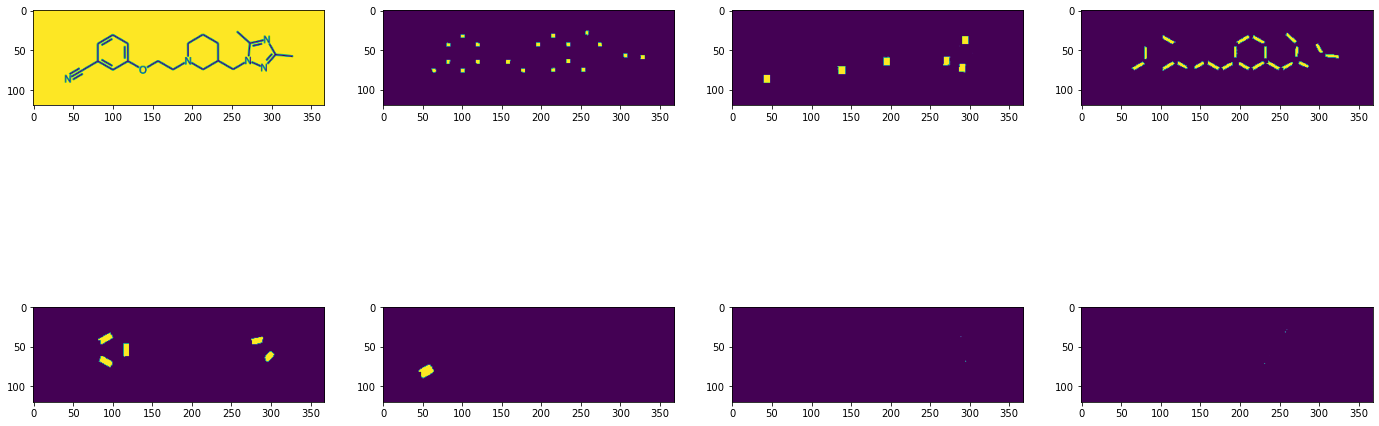

In [36]:
# image, gt_shr, gt_shr_mask, gt_thr, gt_thr_mask = ocr_dataset[idx]
image = ocr_dataset[idx]
# image = ocr_dataset[54]
image = image[None,]

x = model(image)
print(idx)

fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax[0, 0].imshow(image[0, 0].detach().numpy())
# ax[0, 1].imshow(x[0, 0].detach().numpy())
# ax[0, 2].imshow(x[0, 1].detach().numpy())
# ax[0, 3].imshow(x[0, 2].detach().numpy())
ax[0, 1].imshow(x[0, 1].detach().numpy())
ax[0, 2].imshow(x[0, 2].detach().numpy())
ax[0, 3].imshow(x[0, 3].detach().numpy())
ax[1, 0].imshow(x[0, 4].detach().numpy())
ax[1, 1].imshow(x[0, 5].detach().numpy())
ax[1, 2].imshow(x[0, 6].detach().numpy())
ax[1, 3].imshow(x[0, 7].detach().numpy())
# ax[1, 0].imshow(gt_shr.detach().numpy())
# ax[1, 1].imshow(gt_shr.detach().numpy() == 5)
# ax[1, 2].imshow(gt_shr.detach().numpy() == 6)
# ax[1, 3].imshow(gt_shr.detach().numpy() == 7)

idx += 1

In [ ]:
# image, gt_shr, gt_shr_mask, gt_thr, gt_thr_mask = ocr_dataset[idx]
image = ocr_dataset[idx]
# image = Tensor(image[None, None, :, :])
image = image[None,]

x = model(image)

fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax[0, 0].imshow(image[0, 0].detach().numpy())
# ax[0, 1].imshow(x[0, 0].detach().numpy())
# ax[0, 2].imshow(x[0, 3].detach().numpy())
ax[0, 1].imshow(x[0, 4].detach().numpy())
ax[0, 2].imshow(x[0, 5].detach().numpy())
ax[0, 3].imshow(x[0, 6].detach().numpy())
ax[1, 0].imshow(x[0, 7].detach().numpy())
ax[1, 1].imshow(x[0, 8].detach().numpy())
ax[1, 2].imshow(x[0, 9].detach().numpy())
ax[1, 3].imshow(x[0, 10].detach().numpy())

idx += 1

In [4]:
import torch
from torch import nn

from emnist import NeuralNetwork

char_model = NeuralNetwork()
char_model.load_state_dict(torch.load("model_weights.emnist.pth"))
char_model.eval()

NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (7): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Conv2d(512, 62, kernel_size=(1, 1), stride=(1, 1))
)

In [9]:
eminst_class = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
convT2d = torch.nn.ConvTranspose2d(320, 320, 2, 2)

In [5]:
import cv2
from shapely.geometry import Polygon
import numpy as np

from math import ceil



def sqrt_einsum(a, b):
    a_min_b = a - b
    return np.sqrt(np.einsum("i,i->", a_min_b, a_min_b))

def cal_avg_dist(contours):
    _length = []
    limit = 0
    for _polygon in contours:
        limit += 1
        if limit == 30:
            break
        _length.append(sqrt_einsum(_polygon.max(axis=0)[0], _polygon.min(axis=0)[0]))
    _length = np.array(_length, dtype=np.float16)
    return _length.mean()

# def chk_pair(dist_arr):
#     _, _dist_arr = np.where(dist_arr == 1)
#     if np.all(dist_arr.sum(axis=1) == 2):
#         return _dist_arr.reshape(-1, 2).astype(int)
#     else:
#         plt.imshow(dist_arr)
#         raise ValueError

In [56]:
image = ocr_dataset[54]
# image, gt_shr, gt_shr_mask, gt_thr, gt_thr_mask = ocr_dataset[2]
image = image[None,]

neck_out = model.neck(image)
out = model.head(neck_out)
out = out.detach().cpu().numpy()

x = model.head.categorize[:-2](neck_out)
x = convT2d(x)
x = x.detach().numpy()

# idx = 0

In [57]:
def get_pair(array1, array2):
    _dist = np.abs(array1[None, :, :] - array2[:, None, :]).max(axis=2)
    return _dist.min(axis=0).argsort()[:2]

def _buffered_polygon_coords(polygon):
    if not isinstance(polygon, Polygon):
        polygon = Polygon(polygon)
    area = polygon.area
    peri = polygon.length
    buffer_polygon = polygon.buffer(distance=2, cap_style=2, join_style=2)
    return np.array(buffer_polygon.exterior.coords)

def extreme_points(contour):
    extreme_left = tuple(contour[contour[:, :, 0].argmin()][0])
    extreme_right = tuple(contour[contour[:, :, 0].argmax()][0])
    extreme_top = tuple(contour[contour[:, :, 1].argmin()][0])
    extreme_bottom = tuple(contour[contour[:, :, 1].argmax()][0])
    return extreme_left, extreme_right, extreme_top, extreme_bottom

def get_min_max(contours):
    _list = []
    for _polygon in contours:
        max_x, max_y = _polygon.max(axis=0)[0]
        min_x, min_y = _polygon.min(axis=0)[0]
        _max = [ceil(max_x)+3, ceil(max_y)+3]
        _min = [int(min_x)-2, int(min_y)-2]
        _list.append([_max, _min])
    return _list


In [58]:
# %%timeit

contours = {}
for idx in range(1, 3):
    #TODO: var: img
    _contours, _ = cv2.findContours(255*np.array(out[0][idx] > 0.2, dtype=np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    _ctrs = []
    if _contours.__len__() == 0:
        contours[idx] = None
        continue
    for _polygon in _contours:
        if _polygon.shape.__len__() > 1:
            rect = cv2.minAreaRect(_polygon)
            (x, y), (w, h), ang = rect
            box = cv2.boxPoints(rect)
            _ctrs.append([x, y])
    contours[idx] = np.array(_ctrs, dtype=np.float16)
    if idx == 2:
        char_pos = get_min_max(_contours)

def chunk_char(array, cutoff):
    _dist_arr = np.abs(array[None, :, :] - array[:, None, :]).max(axis=2)
    _dist_arr[np.triu_indices(_dist_arr.shape[0])] = 999
    _dist = np.where(_dist_arr < cutoff * 1.2)
    _dist = np.stack(_dist, axis=1)
    return _dist

b_pair = {}
polygons = {}
avg_b_dist = 0
bond_length = []
for idx in range(3, 8):
    #TODO: var: img
    _contours, _ = cv2.findContours(255*np.array(out[0][idx] > 0.2, dtype=np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    _ctrs = []
    _poly = []
    if _contours.__len__() == 0:
        contours[idx] = None
        polygons[idx] = None
        continue
    for _polygon in _contours:
        # _polygon = _polygon.squeeze()
        if cv2.contourArea(_polygon) > 1:
            rect = cv2.minAreaRect(_polygon)
            (x, y), (w, h), ang = rect
            box = cv2.boxPoints(rect)
            _ctrs.append([x, y])
            _poly.append(box)
            bond_length.append([w, h])

    contours[idx] = np.array(_ctrs, dtype=np.float16)
    polygons[idx] = np.array(_poly, dtype=np.float16)

bond_avg_length = np.array(bond_length, dtype=np.float16).max(axis=1).mean()
chunked_char = chunk_char(contours[2], bond_avg_length)

heavy_atom = np.ones(contours[2].__len__(), dtype=np.uint8)

pred_char_list = []

for i in char_pos:
    _max, _min = i
    _image = image[:, :, _min[1]:_max[1], _min[0]:_max[0]]
    # idx += 1
    pred = eminst_class[char_model(_image).argmax()]
    if pred in ['0', 'Q']:
        pred = 'O'
    
    pred_char_list.append(pred)

for i in chunked_char:
    a = pred_char_list[i[0]]
    b = pred_char_list[i[1]]
    if a == 'H':
        heavy_atom[i[0]] = 0
    elif b == 'H':
        heavy_atom[i[1]] = 0

contours[2] = contours[2][np.where(heavy_atom == 1)]
pred_char_list = np.array(pred_char_list)[np.where(heavy_atom == 1)]

pts = np.concatenate([contours[1], contours[2]], axis=0)

for idx in range(3, 8):
    if polygons[idx] is not None:
        b_pair[idx] = []
        for _polygon in polygons[idx]:
            b_pair[idx].append(get_pair(pts, _polygon))


In [59]:
import rdkit
from rdkit import Chem, rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom, rdDepictor, rdCoordGen

IPythonConsole.drawOptions.addAtomIndices = False

In [60]:
b_type_list = {
    3: Chem.BondType.SINGLE,
    4: Chem.BondType.DOUBLE,
    5: Chem.BondType.TRIPLE,
    6: Chem.BondType.SINGLE,
    7: Chem.BondType.SINGLE,
}
b_dir_list = {
    6: Chem.BondDir.BEGINWEDGE,
    7: Chem.BondDir.BEGINDASH,
}

a_list = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9,
    'E': 9,
    'R': 9,
    'S': 16,
}

mol = Chem.RWMol()

a_idx = 0
for _ in contours[1]:
    atom = Chem.Atom(6)
    mol.AddAtom(atom)
    a_idx += 0

for _ in pred_char_list:
    atom = Chem.Atom(a_list[_])
    mol.AddAtom(atom)
    a_idx += 0

b_idx = 0
chiral_b_idx = {}
for idx in b_pair:
    for i, j in b_pair[idx]:
        i = int(i)
        j = int(j)
        mol.AddBond(i, j, order=b_type_list[idx])
        if idx > 5:
            _bond = mol.GetBondWithIdx(b_idx)
            _bond.SetBondDir(b_dir_list[idx])
            chiral_b_idx[b_idx] = [i, j]
        b_idx += 1


conf = Chem.Conformer(mol.GetNumAtoms())
mol.AddConformer(conf)

Chem.SanitizeMol(mol)
# rdDepictor.Compute2DCoords(mol)
Chem.AssignChiralTypesFromBondDirs(mol)

if chiral_b_idx.__len__() != 0:
    for _idx in chiral_b_idx:
        _b = mol.GetBondWithIdx(_idx)
        _bDir = _b.GetBondDir()
        _aI = _b.GetBeginAtom()
        _aJ = _b.GetEndAtom()
        type_bool1 = _aI.GetChiralTag() == Chem.ChiralType.CHI_UNSPECIFIED
        type_bool2 = _aJ.GetChiralTag() == Chem.ChiralType.CHI_UNSPECIFIED
        if type_bool1 and type_bool2:
            j, i = chiral_b_idx[_idx]
            mol.RemoveBond(j, i)
            mol.AddBond(i, j, order=Chem.BondType.SINGLE)
            _b = mol.GetBondWithIdx(b_idx-1)
            _b.SetBondDir(_bDir)

Chem.AssignChiralTypesFromBondDirs(mol)

# Chem.DetectBondStereochemistry(mol)
# Chem.AssignAtomChiralTagsFromStructure(mol)
# Chem.AssignStereochemistry(mol)

Chem.SanitizeMol(mol)
smi = Chem.MolToSmiles(mol)
mol = Chem.MolFromSmiles(smi)
# mol

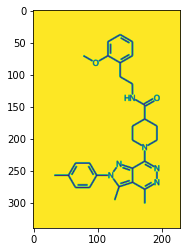

In [61]:
plt.imshow(image[0, 0].detach().numpy())

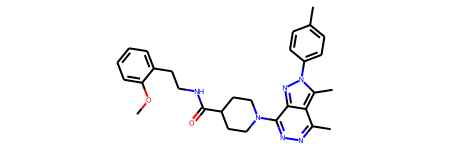

In [62]:
mol

In [ ]:
cgparams = rdCoordGen.CoordGenParams()
cgparams.minimizerPrecision = cgparams.sketcherBestPrecision
rdCoordGen.AddCoords(mol, cgparams)
mol

In [ ]:
type(b_pair[3][0][0])

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax[0, 0].imshow(image[0, 0].detach().numpy())
ax[0, 1].imshow(out[0, 1])
ax[0, 2].imshow(out[0, 2])
ax[0, 3].imshow(out[0, 3])
ax[1, 0].imshow(out[0, 4])
ax[1, 1].imshow(out[0, 5])
ax[1, 2].imshow(out[0, 6])
ax[1, 3].imshow(out[0, 7])

In [ ]:
# for i in contours[1]: plt.scatter(i[0], i[1], s=4200, c='none', edgecolors='k', alpha=0.2)
k = 0
for i in contours[1]: plt.scatter(i[0], i[1], c='k', alpha=0.5)
for i in contours[1]: plt.text(i[0], i[1], k); k += 1
k = 0
# for i in contours[2]: plt.scatter(i[0], i[1], s=4200, c='none', edgecolors='b', alpha=0.2)
for i in contours[2]: plt.scatter(i[0], i[1], c='b', alpha=0.5)
for i in contours[2]: plt.text(i[0], i[1], k); k += 1
k = 0
for i in contours[6]: plt.scatter(i[0], i[1], c='gray', alpha=0.5)
for i in contours[6]: plt.text(i[0], i[1], k, c='gray'); k += 1